In [1]:
import torch
import numpy as np
torch.manual_seed(0)
np.random.seed(0)
print(f"CUDA version: {torch.version.cuda}")  # Should match your nvcc version (12.1)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")  # Should return True

CUDA version: 12.1
PyTorch version: 2.5.0+cu121
CUDA available: True


In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

### Importing data

In [3]:
import os

dataset_dir = 'dataset'
# pdg == parkinson's disease group
# cg == control group

pdg_dir = dataset_dir + '/t2/pd_group_t2_flair/'
pdg_file_paths = [
    pdg_dir + file_path for file_path in os.listdir(pdg_dir)
    if file_path.endswith('.nii')
    and os.path.isfile(os.path.join(pdg_dir, file_path))
    ]
pdg_file_paths = pdg_file_paths[:156]
print("Parkinson's Disease Group Files with extension, .nii:", len(pdg_file_paths))

cg_dir = dataset_dir + '/t2/control_group_t2_flair/'
cg_file_paths = [
    cg_dir + file_path for file_path in os.listdir(cg_dir)
    if file_path.endswith('.nii')
    and os.path.isfile(os.path.join(cg_dir, file_path))
    ]

print("Control Group Files with extension, .nii:", len(cg_file_paths))

Parkinson's Disease Group Files with extension, .nii: 156
Control Group Files with extension, .nii: 156


### Loading data and preprocessing

In [4]:
import nibabel as nib
import numpy as np

from scipy import ndimage

def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def zscore_normalize(volume):
    if volume.ndim > 3:
        volume = volume[:, :, :, 0]

    mean    = np.mean(volume)
    std     = np.std(volume)
    volume  = (volume - mean) / std
    return volume.astype("float32")

def min_max_normalize(volume):
    min_val = np.min(volume)
    max_val = np.max(volume)
    volume = (volume - min_val) / (max_val - min_val + 1e-8)  # Add epsilon to avoid division by zero
    return volume.astype("float32")

def resize_volume(img, filepath):
    if img.ndim > 3:
        img = img[:, :, :, 0]

    # Set desired dimensions
    desired_depth   = 64
    desired_width   = 128
    desired_height  = 128

    # Get current dimensions
    current_depth   = img.shape[-1]
    current_width   = img.shape[0]
    current_height  = img.shape[1]

    # Compute factors
    depth   = current_depth / desired_depth
    width   = current_width / desired_width
    height  = current_height / desired_height
    depth_factor    = 1 / depth
    width_factor    = 1 / width
    height_factor   = 1 / height

    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    
    # Resize across z-axis
    print(f'No. of dimensions: {img.ndim}')
    print(f'Lenght: {len(img)}')
    print(f"Image shape: {img.shape}")
    print(f"Scaling factors: {(width_factor, height_factor, depth_factor)}")
    print(filepath)
    print('-------------------------')

    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = resize_volume(volume, path)
    volume = zscore_normalize(volume)
    #volume = min_max_normalize(volume)
    
    
    return volume

### Building Train and Test datasets

In [5]:
pdg_array   = np.array([process_scan(path) for path in pdg_file_paths])
cg_array    = np.array([process_scan(path) for path in cg_file_paths])

pdg_labels  = np.array([1 for _ in range(len(pdg_array))])
cg_labels   = np.array([0 for _ in range(len(cg_array))])

No. of dimensions: 3
Lenght: 256
Image shape: (256, 256, 37)
Scaling factors: (0.5, 0.5, 1.7297297297297298)
dataset/t2/pd_group_t2_flair/I1120538_BRAIN_WITH_AND_WITHOUT_P_20180517125543_4.nii
-------------------------
No. of dimensions: 3
Lenght: 256
Image shape: (256, 256, 27)
Scaling factors: (0.5, 0.5, 2.3703703703703702)
dataset/t2/pd_group_t2_flair/I1196784_AX_T2_Flair_20190321152927_401.nii
-------------------------
No. of dimensions: 3
Lenght: 256
Image shape: (256, 256, 27)
Scaling factors: (0.5, 0.5, 2.3703703703703702)
dataset/t2/pd_group_t2_flair/I1225072_AX_T2_Flair_20190328144613_401.nii
-------------------------
No. of dimensions: 3
Lenght: 256
Image shape: (256, 256, 42)
Scaling factors: (0.5, 0.5, 1.5238095238095237)
dataset/t2/pd_group_t2_flair/I1350772_PPMI_NEW_PROTOCOL_2016_20181129124926_4.nii
-------------------------
No. of dimensions: 3
Lenght: 288
Image shape: (288, 288, 22)
Scaling factors: (0.4444444444444444, 0.4444444444444444, 2.909090909090909)
dataset/t2

In [6]:
from sklearn.model_selection import train_test_split

X = np.concatenate((pdg_array, cg_array), axis=0)
y = np.concatenate((pdg_labels, cg_labels), axis=0)

# Split with stratification to preserve class balance
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(x_train)}, Test size: {len(x_test)}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution:  {np.bincount(y_test)}")


Train size: 249, Test size: 63
Train class distribution: [124 125]
Test class distribution:  [32 31]


In [7]:
print(y_train)

[1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1
 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0
 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0
 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1
 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0]


### Data Augmentation

##### Rotation and Preporcessing Functions

In [56]:
import random
from scipy import ndimage
import torch

def normalization(volume):
    volume_min = np.min(volume)
    volume_max = np.max(volume)
    if volume_max == volume_min:
        volume = np.zeros_like(volume)
    else:
        volume = (volume - volume_min) / (volume_max - volume_min)
    return volume

def min_max_normalize(volume):
    min_val = np.min(volume)
    max_val = np.max(volume)
    volume = (volume - min_val) / (max_val - min_val + 1e-8)  # Add epsilon to avoid division by zero
    return volume.astype("float32")

def rotate(volume):
    angles  = [-20, -15, -10, -5, 0, 5, 10, 15, 20]
    angle   = random.choice(angles)
    
    volume = ndimage.rotate(volume, angle, reshape=False)
    #volume[volume < 0] = 0
    #volume[volume > 1] = 1
    return volume

def add_noise(volume, noise_factor=0.005):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=volume.shape)
    volume = volume + noise
    #volume = np.clip(volume, 0., 1.)  # Ensure values are within [0, 1]
    return volume

def scale(volume, scale_range=(0.9, 1.1)):
    scale = random.uniform(*scale_range)
    volume = ndimage.zoom(volume, zoom=scale, order=1)  # Linear interpolation
    return volume

def adjust_brightness_contrast(volume, brightness_factor=0.1, contrast_factor=0.1):
    volume = volume + random.uniform(-brightness_factor, brightness_factor)
    #volume = np.clip(volume, 0., 1.)  # Ensure values are within [0, 1]
    #volume[volume < 0] = 0
    #volume = normalization(volume)
    #volume = min_max_normalize(volume)
    return volume

def resize(volume, target_shape=(64, 128, 128)):  # Adjust target_shape as needed
    # Resize the volume to the target shape
    volume = ndimage.zoom(volume, (target_shape[0] / volume.shape[0],
                                    target_shape[1] / volume.shape[1],
                                    target_shape[2] / volume.shape[2]),
                           order=1)  # Linear interpolation
    
    #volume = normalization(volume)
    #volume = min_max_normalize(volume)
    return volume

def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = add_noise(volume)
    volume = scale(volume)
    volume = adjust_brightness_contrast(volume)
    #volume[volume < 0] = 0
    #volume[volume > 1] = 1
    volume = resize(volume)
    #volume = np.clip(volume, 0., 1.)  # Ensure values are within [0, 1]
    volume = normalization(volume)
    volume = torch.Tensor(volume).unsqueeze(0).float()
    return volume, label

def test_preprocessing(volume, label):
    #volume[volume < 0] = 0
    #volume[volume > 1] = 1
    volume = normalization(volume)
    volume = torch.Tensor(volume).unsqueeze(0).float()
    return volume, label

##### Custom PyTorch Dataset

In [57]:
from torch.utils.data import Dataset

class MedicalDataset(Dataset):
    def __init__(self, volumes, labels, is_train=True):
        self.volumes    = volumes
        self.labels     = labels
        self.is_train   = is_train

    def __len__(self):
        return len(self.volumes)
    
    def __getitem__(self, idx):
        volume  = self.volumes[idx]
        label   = self.labels[idx]

        #volume = np.expand_dims(volume, axis=0).astype(np.float32)  # [1, H, W, D]
        volume = np.transpose(volume, (2, 0, 1))  # → [1, D, H, W]

        if self.is_train:
            volume, label = train_preprocessing(volume, label)
        else:
            volume, label = test_preprocessing(volume, label)

        #volume  = torch.tensor(volume, dtype=torch.float32)
        label   = torch.tensor(label, dtype=torch.float32)
        
        return volume, label

#### DataLoader Setup

In [58]:
from torch.utils.data import DataLoader

train_dataset   = MedicalDataset(x_train, y_train, is_train=True)
test_dataset    = MedicalDataset(x_test, y_test, is_train=False)
print("Train dataset shape:", train_dataset[0][0].shape)
print("Test dataset shape:", test_dataset[0][0].shape)

batch_size = 4

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False
)

Train dataset shape: torch.Size([1, 64, 128, 128])
Test dataset shape: torch.Size([1, 64, 128, 128])


In [59]:
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

Train Dataset size: 249
Test Dataset size: 63


##### Visualize scan

Dimension of the scan is: (1, 64, 128, 128)
Label: 1.0


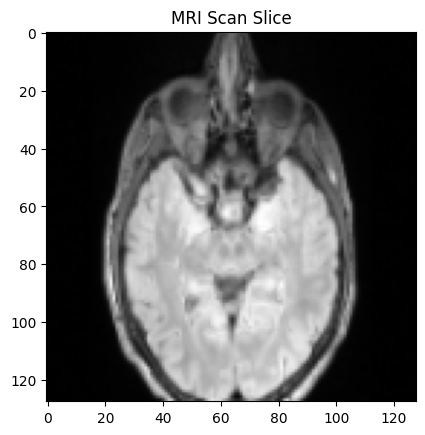

In [60]:
import matplotlib.pyplot as plt
images, labels = train_dataset[0]
images = images.numpy()
print('Dimension of the scan is:', images.shape)
print(f'Label: {labels}')
plt.imshow(np.squeeze(images[:, 32, :, :]), cmap="gray")
plt.title("MRI Scan Slice")
plt.show()

Dimension of the scan is: (1, 64, 128, 128)
Label: 0.0


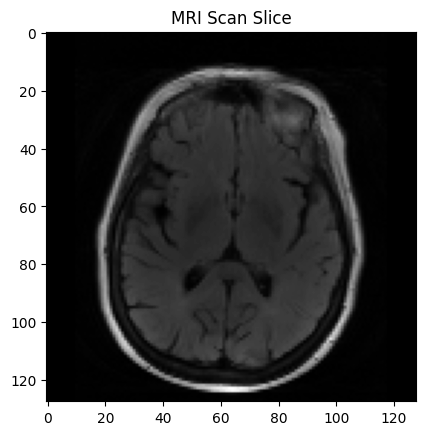

In [61]:
import matplotlib.pyplot as plt
images, labels = test_dataset[1]
images = images.numpy()
print('Dimension of the scan is:', images.shape)
print(f'Label: {labels}')
plt.imshow(np.squeeze(images[:, 32, :, :]), cmap="gray")
plt.title("MRI Scan Slice")
plt.show()

### Define a 3D Convolutional Neural Network

### Load pre-trained model

In [62]:
from torchvision.models.video import r3d_18
model = r3d_18(pretrained=True)

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchinfo

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 1),
    nn.Sigmoid(),
)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [64]:
# Modify input layer for 1-channel input
model.stem[0] = nn.Conv3d(
    in_channels=1,
    out_channels=model.stem[0].out_channels,
    kernel_size=model.stem[0].kernel_size,
    stride=model.stem[0].stride,
    padding=model.stem[0].padding,
    bias=model.stem[0].bias is not None,
)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Train model

##### Model definition

In [65]:
import torch
import torch.optim as optim
from  torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Initialize model, loss function, optimizer and scheduler
#model = ParkinsonCNN()
criterion = nn.BCELoss() # Binary cross-entropy loss
initial_lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = ExponentialLR(optimizer, gamma=0.96) # Decay rate

# Moving model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [66]:
parameters = model.parameters()
paramenter_count = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {paramenter_count}')

Number of parameters: 33410625


##### Training Function

In [67]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels.view(-1, 1)).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

##### Test Function

In [68]:
def test_epoch(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels.view(-1, 1)).sum().item()
            total += labels.size(0)
        
    test_loss /= len(test_loader)
    test_acc = correct / total
    return test_loss, test_acc

In [69]:
for inputs, labels in train_loader:
    print("Inputs shape:", inputs.shape)  # Should be [batch_size, 1, 128, 128, 64]
    print("Labels shape:", labels.shape)  # Should be [batch_size, 1]
    print("Unique labels:", torch.unique(labels))  # Should only show [0, 1]
    break

Inputs shape: torch.Size([4, 1, 64, 128, 128])
Labels shape: torch.Size([4])
Unique labels: tensor([0., 1.])


##### Training Loop (early stopping and checkpoints)

In [70]:
epochs = 100

# Define early stopping and checkpoint variables
best_test_acc = 0
early_stop_count = 0
patience = 30 # Number of epochs with no improvement to trigger early stopping

train_acc_list = list()
train_loss_list = list()
test_acc_list = list()
test_loss_list = list()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_epoch(model, test_loader, criterion)

    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

    # Learning rate scheduling
    scheduler.step()

    # Checkpoint: Save the best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        early_stop_count = 0
        torch.save(model.state_dict(), 'parkinson_classification_RESNET.pth')
        print("Model checkpoint saved!")
    else:
        early_stop_count += 1
    
    #Early stopping
    if early_stop_count >= patience:
        print("Early stopping triggered")
        print(f"Best Test Accuracy: {best_test_acc:.4f}")
        break

Epoch 1/100
Train loss: 0.6913, Train accuracy: 0.5422
Test loss: 0.6965, Test accuracy: 0.4921
Model checkpoint saved!
Epoch 2/100
Train loss: 0.6818, Train accuracy: 0.5984
Test loss: 0.6788, Test accuracy: 0.6825
Model checkpoint saved!
Epoch 3/100
Train loss: 0.6731, Train accuracy: 0.6145
Test loss: 0.6767, Test accuracy: 0.6984
Model checkpoint saved!
Epoch 4/100
Train loss: 0.6669, Train accuracy: 0.6426
Test loss: 0.6700, Test accuracy: 0.6984
Epoch 5/100
Train loss: 0.6571, Train accuracy: 0.6707
Test loss: 0.6668, Test accuracy: 0.6825
Epoch 6/100
Train loss: 0.6535, Train accuracy: 0.6867
Test loss: 0.6631, Test accuracy: 0.6825
Epoch 7/100
Train loss: 0.6489, Train accuracy: 0.7068
Test loss: 0.6594, Test accuracy: 0.6667
Epoch 8/100
Train loss: 0.6463, Train accuracy: 0.7269
Test loss: 0.6557, Test accuracy: 0.6984
Epoch 9/100
Train loss: 0.6488, Train accuracy: 0.6707
Test loss: 0.6536, Test accuracy: 0.6984
Epoch 10/100
Train loss: 0.6472, Train accuracy: 0.7028
Test los

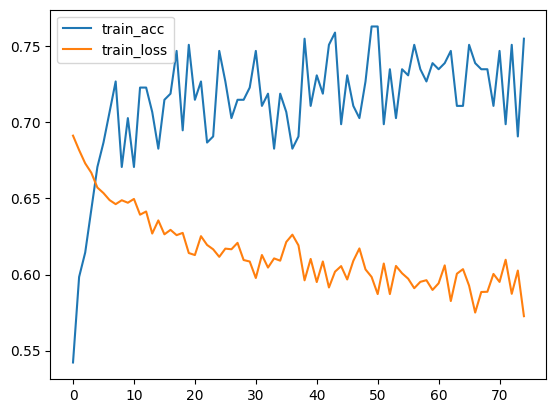

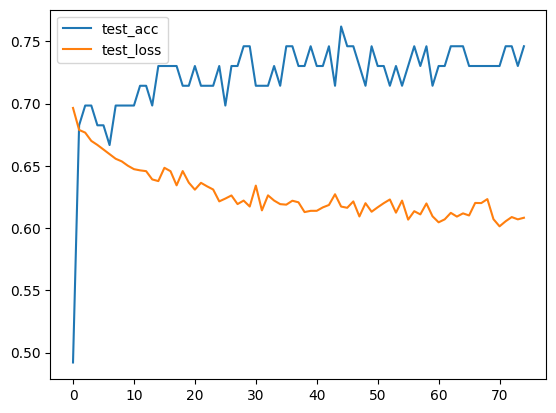

In [71]:
import matplotlib.pyplot as plt
plt.plot(train_acc_list, label='train_acc')
plt.plot(train_loss_list, label='train_loss')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
plt.plot(test_acc_list, label='test_acc')
plt.plot(test_loss_list, label='test_loss')
plt.legend()
plt.show()

#### Load trained model

In [ ]:
import torch
model.load_state_dict(torch.load('parkinson_classification_RESNET.pth'))
model.eval()

C:\Users\dante\AppData\Local\Temp\ipykernel_7816\4132649546.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('parkinson_classification_RE

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

No. of dimensions: 3
Lenght: 192
Image shape: (192, 256, 256)
Scaling factors: (0.6666666666666666, 0.5, 0.25)
dataset/t2/pd_t2_sagital/I1490509_Anon_20210302144514_6.nii
-------------------------
Dimension of the scan is: torch.Size([1, 128, 128, 64])


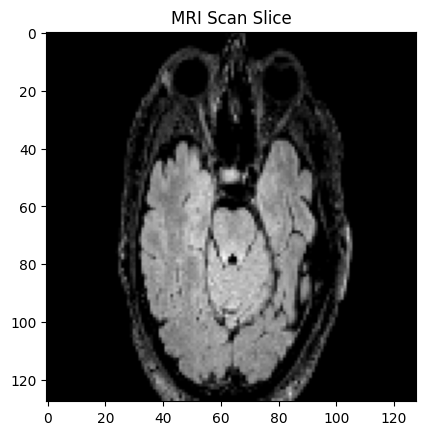

Model output: tensor([[0.6380]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Prediction: 1
Parkinson’s Disease


: 

In [ ]:
import nibabel as nib
import numpy as np

from scipy import ndimage

def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def zscore_normalize(volume):
    if volume.ndim > 3:
        volume = volume[:, :, :, 0]

    mean    = np.mean(volume)
    std     = np.std(volume)
    volume  = (volume - mean) / std
    return volume.astype("float32")

def min_max_normalize(volume):
    min_val = np.min(volume)
    max_val = np.max(volume)
    volume = (volume - min_val) / (max_val - min_val + 1e-8)  # Add epsilon to avoid division by zero
    return volume.astype("float32")

def resize_volume(img, filepath):
    # Set desired dimensions
    desired_depth   = 64
    desired_width   = 128
    desired_height  = 128

    # Get current dimensions
    current_depth   = img.shape[-1]
    current_width   = img.shape[0]
    current_height  = img.shape[1]

    # Compute factors
    depth   = current_depth / desired_depth
    width   = current_width / desired_width
    height  = current_height / desired_height
    depth_factor    = 1 / depth
    width_factor    = 1 / width
    height_factor   = 1 / height

    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    
    # Resize across z-axis
    print(f'No. of dimensions: {img.ndim}')
    print(f'Lenght: {len(img)}')
    print(f"Image shape: {img.shape}")
    print(f"Scaling factors: {(width_factor, height_factor, depth_factor)}")
    print(filepath)
    print('-------------------------')

    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = zscore_normalize(volume)
    #min_max_normalize(volume)
    volume = resize_volume(volume, path)
    return volume

nifti_file = 'dataset/t2/pd_t2_sagital/I1490509_Anon_20210302144514_6.nii'
nifti_array = np.array(process_scan(nifti_file))

volume = nifti_array
volume[volume < 0] = 0
#volume[volume > 1] = 1
volume = torch.Tensor(volume).unsqueeze(0)

import matplotlib.pyplot as plt

print('Dimension of the scan is:', volume.shape)
plt.imshow(np.squeeze(volume[0, :, :, 32]), cmap="gray")
plt.title("MRI Scan Slice")
plt.show()

volume = volume.unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Perform inference
output = model(volume.to(device))

print(f"Model output: {output}")

# Threshold at 0.5 for binary classification
pred = 1 if output.item() > 0.5 else 0
print(f"Prediction: {pred}")

# Interpret the prediction
if pred == 1:
    print('Parkinson’s Disease')
else:
    print('Control Group')

In [ ]:
logits_list = list()
prob_list = list()
model.eval()
with torch.no_grad():
    for volume, label in test_loader:
        volume = volume.to(device)
        
        output = model(volume)
        logits = output
        logits_list.append(np.array(output.to('cpu')).squeeze(1))

        #probabilities = torch.sigmoid(logits) if logits.shape[1] == 1 else torch.softmax(logits, dim=1)
        #prob_list.append(probabilities)
        #preds = torch.argmax(probabilities, dim=1)
        #print(f"Logits: {logits}, Probabilities: {probabilities}, Predictions: {preds}, Ground Truth: {label}")


C:\Users\dante\AppData\Local\Temp\ipykernel_7816\1248209589.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume  = torch.tensor(volume, dtype=torch.float32)


In [ ]:
print(logits_list)

[array([0.63534206, 0.41367233], dtype=float32), array([0.491984 , 0.6108431], dtype=float32), array([0.23188478, 0.43669805], dtype=float32), array([0.467273  , 0.57500196], dtype=float32), array([0.5779203, 0.6529614], dtype=float32), array([0.6233138 , 0.51697856], dtype=float32), array([0.5698477 , 0.49605185], dtype=float32), array([0.46383253, 0.5594224 ], dtype=float32), array([0.5210377 , 0.40507537], dtype=float32), array([0.45732898, 0.45753023], dtype=float32), array([0.46792084, 0.47127563], dtype=float32), array([0.33268458, 0.3470331 ], dtype=float32), array([0.5406054 , 0.32627288], dtype=float32), array([0.54075545, 0.3556927 ], dtype=float32), array([0.5275201, 0.6097305], dtype=float32), array([0.4464301 , 0.47599676], dtype=float32), array([0.3963225 , 0.48757273], dtype=float32), array([0.53926903, 0.55285704], dtype=float32), array([0.500055  , 0.64190197], dtype=float32), array([0.49220693, 0.36376837], dtype=float32), array([0.3316605, 0.5989455], dtype=float32),

In [ ]:
from sklearn.metrics import roc_curve


# Example with logits and ground truth
# Ground truth (0 = CG, 1 = PD)
logits_list = np.array(logits_list).flatten()
y_true = []
for volume, label in test_loader:
    y_true.append(label)

y_true = np.array(y_true).flatten()
print(len(y_true))
y_scores = logits_list  # Logits or probabilities
print(len(y_scores))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")


56
56
Optimal threshold: 0.46792083978652954


C:\Users\dante\AppData\Local\Temp\ipykernel_7816\1248209589.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume  = torch.tensor(volume, dtype=torch.float32)
